# Pendientes

Nada

# Gpu

In [72]:
!nvidia-smi

Wed Oct  1 13:54:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [73]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Set_Up

In [74]:

root_data = f'/content/drive/MyDrive/Course Folder/Forex/XAUUSD/'
print(root_data)

direction = 'Short'
direction_number = -1

symbol = 'XAUUSD'
strategy = 'Kalman'
time_frame = 'M5'

trade_evolution = 'st_Max'
result_field = 'st_PnL'


/content/drive/MyDrive/Course Folder/Forex/XAUUSD/


# Libraries

In [75]:
!pip install ta-lib
import talib as ta
print(ta.__version__)

0.6.7


In [76]:
import numpy as np
import pandas as pd
import os
import joblib
import math
import time

from itertools import combinations, product

from tqdm.auto import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

from xgboost import XGBClassifier, XGBRegressor

import tensorflow as tf

import sys
sys.path.append("..")

from __future__ import annotations
from typing import Tuple, List, Optional, Dict, Any, Union

from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, log_loss, r2_score)

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn-v0_8-darkgrid")

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Calculate_Features



## Features

In [127]:
def kalman_line(source, kalman_length: int, smooth: int):
    """
    Pine -> Python (solo 'kalman_line'), replicando la EMA de TradingView con
    *semilla SMA* (como ta.ema) sobre el núcleo Kalman kf_c.

    Parámetros
    ----------
    source : pd.Series o array-like de floats (precio crudo, sin diff/returns)
    kalman_length : int   (equivale a length_kal en Pine)
    smooth : int          (equivale a smooth_kal en Pine -> ta.ema(kf_c, smooth))

    Retorna
    -------
    Mismo tipo que `source`: pd.Series o np.ndarray con la línea Kalman suavizada.
    """
    import numpy as np
    import pandas as pd

    # normalizamos tipos
    is_series = hasattr(source, "index")
    idx = source.index if is_series else None
    x = np.asarray(source, dtype=np.float64)
    n = x.shape[0]
    if n == 0:
        return source

    # ---------- núcleo Kalman idéntico al Pine ----------
    sqrt_term   = np.sqrt((kalman_length / 10000.0) * 2.0)
    length_term = kalman_length / 10000.0

    kf_c   = np.empty(n, dtype=np.float64)
    velo_c = np.empty(n, dtype=np.float64)

    # bar 0 (nz(kf_c[1], source) y nz(velo_c[1], 0))
    kf_c[0] = x[0]
    velo_c[0] = 0.0

    for i in range(1, n):
        prev_kf = kf_c[i - 1]
        dk_c = x[i] - prev_kf
        smooth_c = prev_kf + dk_c * sqrt_term
        velo_c[i] = velo_c[i - 1] + length_term * dk_c
        kf_c[i] = smooth_c + velo_c[i]

    # ---------- EMA con semilla SMA (comportamiento ta.ema de TV) ----------
    L = int(max(1, smooth))
    alpha = 2.0 / (L + 1.0)
    ema = np.full(n, np.nan, dtype=np.float64)

    if n < L:
        # con pocas barras, igualamos al promedio simple disponible
        ema[-1] = np.nanmean(kf_c)
    else:
        # seed = SMA de las primeras L barras
        seed = np.mean(kf_c[:L])
        ema[L - 1] = seed
        for i in range(L, n):
            ema[i] = alpha * kf_c[i] + (1.0 - alpha) * ema[i - 1]

    return (pd.Series(ema, index=idx) if is_series else ema)


In [128]:
def create_features(
    stock_data: pd.DataFrame,
    return_components: bool = False
) -> Union[pd.DataFrame, Tuple[pd.DataFrame, Dict[str, pd.DataFrame]]]:

    kalman_periods = [300, 600, 900]
    kalman_smooth_kal = 3

    component_frames: Dict[str, pd.DataFrame] = {}

    def _unique_pairwise(columns: List[str]) -> List[Tuple[str, str]]:
        """Return ordered unique column pairs without self-pairings."""
        unique_columns = list(dict.fromkeys(columns))
        return list(combinations(unique_columns, 2))

    # ───────────────────────── Kalman y derivados ───────────────────────
    t0 = time.time()
    kal_cols = []
    kalman_features = pd.DataFrame(index=stock_data.index)
    kalman_900_series: Optional[pd.Series] = None
    for period in tqdm(kalman_periods, desc="Kalman & Derivatives"):
        kal = pd.Series(
            kalman_line(stock_data['Close'], kalman_length=period, smooth=kalman_smooth_kal),
            index=stock_data.index
        )

        if kal.isna().any():
            kal = kal.ffill()
            if kal.isna().any():
                kal = kal.bfill()
        kname = f'Kal_{period}'
        kal_cols.append(kname)

        kalman_features[kname] = kal
        if period == 900:
            kalman_900_series = kal

    tqdm.write(f"[Timing] Kalman block: {time.time()-t0:.2f}s")
    component_frames['Kalman'] = kalman_features.copy()
    features = kalman_features.copy()

    if return_components:
        component_frames['Create_Features'] = features.copy()
        return features, component_frames

    return features

In [129]:
def scale_minmax(features: pd.DataFrame, window: int) -> pd.DataFrame:
    """Apply Min-Max scaling using a rolling window.

    Parameters
    ----------
    features : pd.DataFrame
        Feature block to scale.
    window : int
        Rolling window size.

    Returns
    -------
    pd.DataFrame
        Min-Max scaled feature block preserving the original index.
    """
    if features.empty:
        return pd.DataFrame(index=features.index)

    numeric_cols = features.select_dtypes(include=np.number).columns
    if numeric_cols.empty:
        return pd.DataFrame(index=features.index)

    scaled_features = pd.DataFrame(index=features.index)
    for col in numeric_cols:
        rolling = features[col].rolling(window=window, min_periods=window)
        rolling_min = rolling.min()
        rolling_max = rolling.max()

        range_ = (rolling_max - rolling_min).replace(0, np.nan)
        scaled_features[col] = (features[col] - rolling_min) / range_

    return scaled_features

def apply_minmax_scaling(
    features: pd.DataFrame,
    windows: Tuple[int, ...] = (3),
    prefix: str = "a_minimal_"
) -> pd.DataFrame:
    """Apply Min-Max scaling using multiple rolling window lengths.

    Parameters
    ----------
    features : pd.DataFrame
        Feature block to scale.
    windows : Tuple[int, ...], optional
        Collection of rolling window sizes to apply, by default (3).
    prefix : str, optional
        Prefix to add to each generated Min-Max column, by default "a_minimal_".

    Returns
    -------
    pd.DataFrame
        DataFrame with Min-Max scaled features for the requested windows.
    """
    if features.empty:
        return pd.DataFrame(index=features.index)

    scaled_blocks = []
    for window in windows:
        if window <= 1:
            continue
        window_scaled = scale_minmax(features, window=window)
        if window_scaled.empty:
            continue
        rename_map = {col: f"{prefix}{col}_minmax_{window}" for col in window_scaled.columns}
        scaled_blocks.append(window_scaled.rename(columns=rename_map))

    if not scaled_blocks:
        return pd.DataFrame(index=features.index)

    return pd.concat(scaled_blocks, axis=1)


In [130]:
def scale_feature_block(features: pd.DataFrame, window: int = 200) -> pd.DataFrame:
    """Scale features using a rolling window standardization.

    Parameters
    ----------
    features : pd.DataFrame
        Feature block to scale.
    window : int, optional
        Rolling window size, by default 200.

    Returns
    -------
    pd.DataFrame
        Scaled feature block preserving the original index.
    """
    if features.empty:
        return features.copy()

    numeric_cols = features.select_dtypes(include=np.number).columns
    scaled_features = features.copy()

    if not numeric_cols.empty:
        rolling = features[numeric_cols].rolling(window=window, min_periods=window)
        mean = rolling.mean()
        std = rolling.std()

        std = std.replace(0, np.nan)

        scaled_features[numeric_cols] = (features[numeric_cols] - mean) / std

    return scaled_features


## 5_min

In [136]:
# Read the CSV file
df_5min = pd.read_csv(root_data + 'Data/'+symbol+'_M5.csv', index_col=0)
df_5min.index = pd.to_datetime(df_5min.index)
df_5min = df_5min.iloc[-10000:,]

print('Min_Date : ', df_5min.index.min())
print('Min_Date : ', df_5min.index.max())
print('Number_Rows = ',len(df_5min.index))
print('\n')

df_5min.tail()

Min_Date :  2025-06-05 12:10:00
Min_Date :  2025-07-25 23:55:00
Number_Rows =  10000




,Open,High,Low,Close,Volume,Spread
Date,,,,,,
2025-07-25 23:35:00,3338.59,3339.14,3338.04,3338.81,197,5
2025-07-25 23:40:00,3338.81,3338.92,3337.56,3338.69,194,5
2025-07-25 23:45:00,3338.69,3338.69,3336.64,3336.73,195,40
2025-07-25 23:50:00,3336.73,3336.86,3336.12,3336.52,192,40
2025-07-25 23:55:00,3336.52,3336.88,3336.44,3336.80,82,40


**Features**

In [137]:
start_time = time.time()

features_5min_raw, components_5min = create_features(df_5min, return_components=True)
valid_index_5min = features_5min_raw.index

m5_raw_blocks: Dict[str, pd.DataFrame] = {name: frame.loc[valid_index_5min].copy()
                                           for name, frame in components_5min.items()}
m5_raw_blocks['Create_Features'] = features_5min_raw

m5_scaled_blocks: Dict[str, pd.DataFrame] = {}
m5_raw_paths: Dict[str, str] = {}
m5_scaled_paths: Dict[str, str] = {}

for name, frame in m5_raw_blocks.items():
    filename_raw = f"{symbol}_M5_{name}_Raw_Features.csv" if name != 'Create_Features' else f"{symbol}_M5_Raw_Features.csv"
    raw_path = os.path.join(root_data, 'Results', filename_raw)
    frame.to_csv(raw_path)
    m5_raw_paths[name] = raw_path

    frame_filled = frame.ffill()

    # Apply specific scaling and min-max scaling to Kalman features
    kalman_features_to_scale = frame_filled[['Kal_300', 'Kal_600', 'Kal_900']].copy()
    scaled_kalman = scale_feature_block(kalman_features_to_scale, window=900)
    minmax_kalman = apply_minmax_scaling(kalman_features_to_scale, windows=(3,), prefix="minmax_")


    # Rename columns with specified prefixes
    scaled_kalman = scaled_kalman.rename(columns={col: f"scale_{col}" for col in scaled_kalman.columns})
    minmax_kalman = minmax_kalman.rename(columns={col: f"{col}" for col in minmax_kalman.columns})


    # Combine scaled and min-max features with the rest of the frame
    combined_scaled = frame_filled.drop(columns=['Kal_300', 'Kal_600', 'Kal_900']).copy() # Drop original Kalman
    combined_scaled = pd.concat([combined_scaled, scaled_kalman, minmax_kalman], axis=1) # Add scaled and minmax

    m5_scaled_blocks[name] = combined_scaled
    filename_scale = f"{symbol}_M5_{name}_Scale_Features.csv" if name != 'Create_Features' else f"{symbol}_M5_Scale_Features.csv"
    scale_path = os.path.join(root_data, 'Results', filename_scale)
    combined_scaled.to_csv(scale_path)
    m5_scaled_paths[name] = scale_path


execution_time = time.time() - start_time

print(f"Number of features are: {features_5min_raw.shape[1]}")
print(features_5min_raw.shape)
print(f"Execution time: {execution_time:.2f} seconds")
print(f"Saved {len(m5_raw_blocks) * 2} DataFrames for the M5 timeframe.")
features_5min_raw.tail(5)

Kalman & Derivatives:   0%|          | 0/3 [00:00<?, ?it/s]

[Timing] Kalman block: 0.05s
Number of features are: 3
(10000, 3)
Execution time: 0.37 seconds
Saved 4 DataFrames for the M5 timeframe.


,Kal_300,Kal_600,Kal_900
Date,,,
2025-07-25 23:35:00,3337.487742,3337.520497,3337.729799
2025-07-25 23:40:00,3337.666494,3337.864862,3338.139540
2025-07-25 23:45:00,3337.579710,3337.763807,3337.947434
2025-07-25 23:50:00,3337.362996,3337.464038,3337.522690
2025-07-25 23:55:00,3337.152870,3337.188822,3337.167067


In [138]:
print("NaN counts per column (sorted):")
print(m5_raw_blocks['Create_Features'].isnull().sum().sort_values(ascending=False), '')

NaN counts per column (sorted):
Kal_300    0
Kal_600    0
Kal_900    0
dtype: int64 


In [139]:
print("Saved raw feature files:")
for name, path in m5_raw_paths.items():
    print(f" - {name}: {path}")

Saved raw feature files:
 - Kalman: /content/drive/MyDrive/Course Folder/Forex/XAUUSD/Results/XAUUSD_M5_Kalman_Raw_Features.csv
 - Create_Features: /content/drive/MyDrive/Course Folder/Forex/XAUUSD/Results/XAUUSD_M5_Raw_Features.csv


In [140]:
print(list(features_5min_raw.columns))

['Kal_300', 'Kal_600', 'Kal_900']


**Scale_features**

In [141]:
print("Saved scaled feature files:")
for name, path in m5_scaled_paths.items():
    print(f" - {name}: {path}")


Saved scaled feature files:
 - Kalman: /content/drive/MyDrive/Course Folder/Forex/XAUUSD/Results/XAUUSD_M5_Kalman_Scale_Features.csv
 - Create_Features: /content/drive/MyDrive/Course Folder/Forex/XAUUSD/Results/XAUUSD_M5_Scale_Features.csv


In [142]:
m5_scaled_blocks['Create_Features'].head()

,scale_Kal_300,scale_Kal_600,scale_Kal_900,minmax_Kal_300_minmax_3,minmax_Kal_600_minmax_3,minmax_Kal_900_minmax_3
Date,,,,,,
2025-06-05 12:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-05 12:15:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-05 12:20:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-05 12:25:00,NaN,NaN,NaN,1.0,1.0,1.0
2025-06-05 12:30:00,NaN,NaN,NaN,1.0,1.0,1.0


In [143]:
print("NaN counts per column (scaled, sorted):")
print(m5_scaled_blocks['Create_Features'].isnull().sum().sort_values(ascending=False), '')

NaN counts per column (scaled, sorted):
scale_Kal_300              899
scale_Kal_600              899
scale_Kal_900              899
minmax_Kal_300_minmax_3      3
minmax_Kal_600_minmax_3      3
minmax_Kal_900_minmax_3      3
dtype: int64 


In [144]:
print("M5 feature blocks:", list(m5_raw_blocks.keys()))

M5 feature blocks: ['Kalman', 'Create_Features']


**Plots**

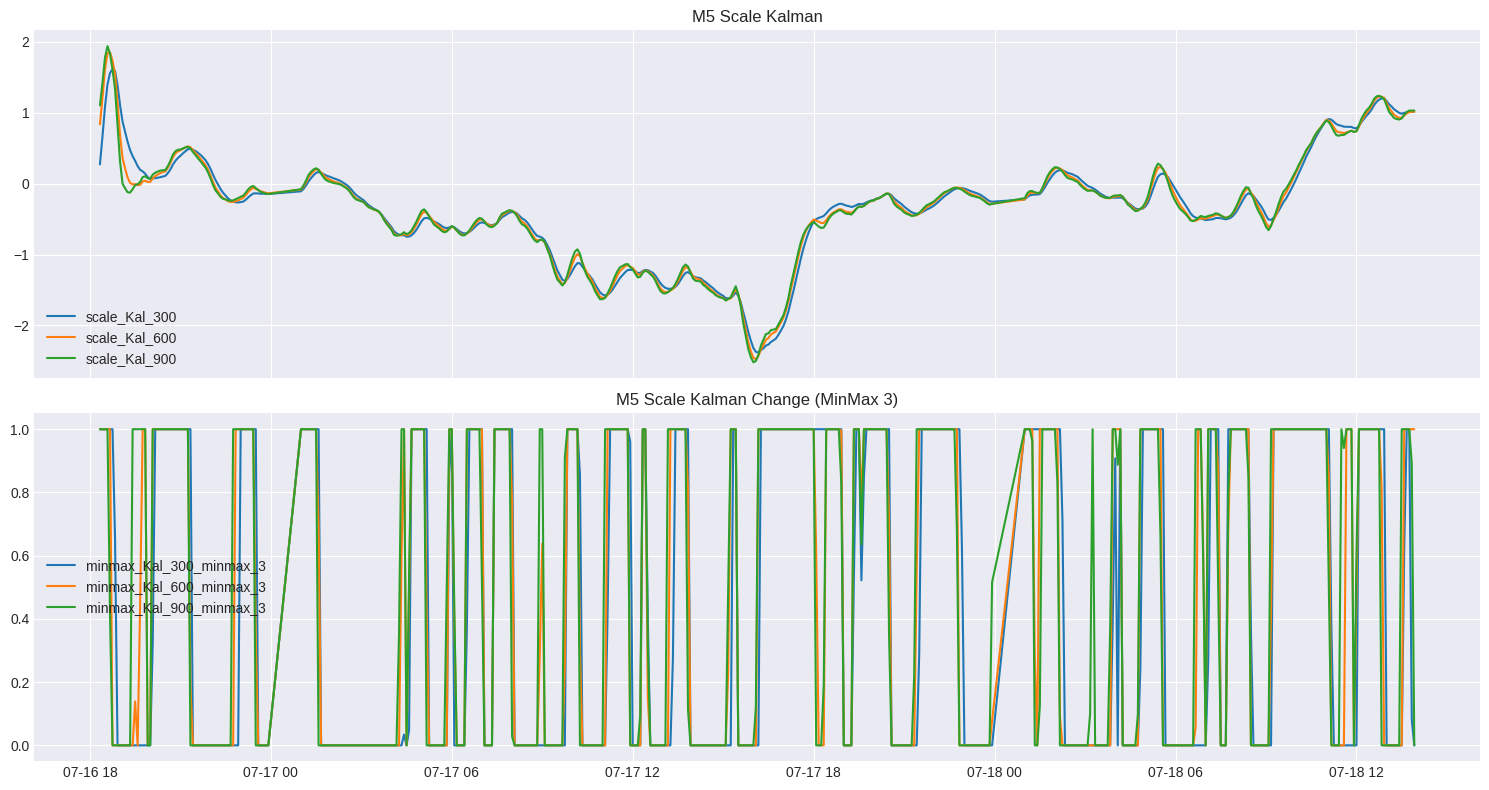

In [147]:
import matplotlib.pyplot as plt

# Define the row range for plotting
start_row = 8000
end_row = 8500

# Select the data for the specified row range from the scaled features
plot_df = m5_scaled_blocks['Create_Features'].iloc[start_row:end_row].copy()
plot_df['Date'] = plot_df.index # Add Date column from index for plotting

# Define the columns to plot in each chart
chart1_cols = ['scale_Kal_300', 'scale_Kal_600', 'scale_Kal_900']
chart2_cols = ['minmax_Kal_300_minmax_3', 'minmax_Kal_600_minmax_3', 'minmax_Kal_900_minmax_3']


# Determine the number of subplots (only include charts with available columns in plot_df)
num_plots = 0
if any(col in plot_df.columns for col in chart1_cols): num_plots += 1
if any(col in plot_df.columns for col in chart2_cols): num_plots += 1


# Create the subplots
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(15, 4 * num_plots), sharex=True)

# Ensure axes is an array even if only one plot
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

current_plot_index = 0

# Plot Chart 1: M5 Scale Kalman indicators
if any(col in plot_df.columns for col in chart1_cols):
    axes[current_plot_index].plot(plot_df['Date'], plot_df[chart1_cols])
    axes[current_plot_index].set_title('M5 Scale Kalman')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart1_cols)
    current_plot_index += 1

# Plot Chart 2: M5 Scale Kalman Change indicators
if any(col in plot_df.columns for col in chart2_cols):
    axes[current_plot_index].plot(plot_df['Date'], plot_df[chart2_cols])
    axes[current_plot_index].set_title('M5 Scale Kalman Change (MinMax 3)')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart2_cols)
    current_plot_index += 1


plt.tight_layout()
plt.show()

# Feature Importance

## Labels

In [94]:
lab = pd.read_csv(root_data + 'Results/'+symbol+'_'+strategy+'_'+time_frame+'_Strategy_Gen_Labels.csv', index_col=0)
lab['Date'] = pd.to_datetime(lab['Date'])

print('Min_Date    : ',lab['Date'].min())
print('Min_Date    : ',lab['Date'].max(),'\n')
print('Number_Rows : ',lab.shape,'\n')
print('Columns     : ',lab.columns)

lab['Open_Trade'].value_counts()

Min_Date    :  2019-01-02 01:00:00
Min_Date    :  2025-07-25 23:55:00 

Number_Rows :  (465718, 32) 

Columns     :  Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Spread', 'ATR',
       'kal_1', 'kal_2', 'kal_3', 'kal_4', 'Open_Trade', 'Close_Trade',
       'Entry_Date', 'Type', 'Trade_Number', 'st_Exit_Date',
       'consecutive_trade_period', 'atr_base_change_abs', 'atr_base_change_%',
       'trade type', 'st_Duration', 'st_row_PnL_close', 'st_row_PnL_high',
       'st_row_PnL_Low', 'st_row_PnL_low', 'st_Max', 'st_Min', 'st_PnL',
       'st_atr_PnL', 'st_atr_max_PnL'],
      dtype='object')


,count
Open_Trade,
1.0,33915
-1.0,33858


In [95]:
#analyse_column = 'st_atr_max_PnL'
analyse_column = 'st_Max'

st_max_0  = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),:]['Open_Trade'].count()
st_max_1  = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),analyse_column].mean()
st_max_2  = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] >= 1.93),analyse_column].sum()
st_max_25 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] <= 1.93),analyse_column].sum()


st_max_3 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] <= 0)),analyse_column].sum()

st_max_4 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 0.7) & (lab['st_atr_max_PnL'] <= 1)),analyse_column].sum()

st_max_5 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 1) &
                   (lab['st_atr_max_PnL'] <= 1.5)),analyse_column].sum()

st_max_6 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 1.5) &
                   (lab['st_atr_max_PnL'] <= 2)),analyse_column].sum()

st_max_7 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 2)),analyse_column].sum()


print(f'Total_Trades = {st_max_0:,.0f}\n')
print(f'Mean st_atr_max_PnL = {st_max_1:,.2f}\n')
print(f'Above_Mean = {st_max_2:,.2f}')
print(f'Below_Mean = {st_max_25:,.2f}\n')

print(f'<= 0.5 = {st_max_3:,.2f}')
print(f'> 0.5 & <= 1 = {st_max_4:,.2f}')
print(f'> 1 & <= 1.5 = {st_max_5:,.2f}')
print(f'> 1.5 & <= 2 = {st_max_6:,.2f}')
print(f'> 2 = {st_max_7:,.2f}')

Total_Trades = 67,773

Mean st_atr_max_PnL = 238.39

Above_Mean = 11,463,914.00
Below_Mean = 4,691,967.00

<= 0.5 = 33.00
> 0.5 & <= 1 = 801,960.00
> 1 & <= 1.5 = 1,411,119.00
> 1.5 & <= 2 = 1,400,438.00
> 2 = 11,277,394.00


In [96]:
analyse_column = 'st_atr_max_PnL'

st_max_0 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),:]['Open_Trade'].count()
st_max_1 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),analyse_column].mean()
st_max_2 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] >= 1.93),analyse_column].count()
st_max_25 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] <= 1.93),analyse_column].count()

st_max_3 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                    (lab['st_atr_max_PnL'] <= 0.5)),analyse_column].count()

st_max_4 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                     (lab['st_atr_max_PnL'] >= 0.5) & (lab['st_atr_max_PnL'] <= 1)),analyse_column].count()

st_max_5 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] >= 1), analyse_column].count()

print(f'Total_Trades = {st_max_0:,.0f}\n')
print(f'Mean st_atr_max_PnL = {st_max_1:,.2f}\n')
print(f'Above_Mean = {st_max_2:,.2f}')
print(f'Below_Mean = {st_max_25:,.2f}\n')

print(f'<= 0.5 = {st_max_3:,.2f}')
print(f'> 0.5 & <= 1 = {st_max_4:,.2f}')
print(f'> 1 = {st_max_5:,.2f}')


Total_Trades = 67,773

Mean st_atr_max_PnL = 1.89

Above_Mean = 20,857.00
Below_Mean = 46,913.00

<= 0.5 = 20,431.00
> 0.5 & <= 1 = 13,116.00
> 1 = 34,223.00


In [97]:
# --- Parámetros / campos
result_field = 'st_atr_max_PnL'

#valid = (
#    (lab['Type'] == direction) &
#    (lab['Open_Trade'].isin([1, -1])) &
#    (lab[result_field].notna()))

valid = (
    (lab['Open_Trade'].isin([1, -1])) &
    (lab[result_field].notna()))


# --- Etiquetado en la columna "label" con valores 4/5/6
lab['label'] = np.nan
lab.loc[valid & (lab[result_field] <= 1), 'label'] = 0
lab.loc[valid & (lab[result_field] >= 1), 'label'] = 1


# --- Mantener solo filas válidas y con label
lab = lab.loc[valid & lab['label'].notna()].copy()
lab['label'] = lab['label'].astype('int8')

# --- Ver distribución de labels 4/5/6
print('\nValue counts de label 4/5/6:')
print(lab['label'].value_counts(dropna=False).sort_index())



Value counts de label 4/5/6:
label
0    33547
1    34223
Name: count, dtype: int64


## Features

In [107]:
raw_feat_5min = pd.read_csv(root_data+'Results/'+symbol+'_M5_Raw_Features.csv')
raw_feat_5min["Date"] = pd.to_datetime(raw_feat_5min["Date"])
print(raw_feat_5min.shape)
#raw_feat_5min.head(5)

(10000, 4)


In [108]:
scale_feat_5min = pd.read_csv(root_data+'Results/'+symbol+'_M5_Scale_Features.csv')
#scale_feat_5min = scale_feat_5min.drop('Unnamed: 0', axis=1)
scale_feat_5min["Date"] = pd.to_datetime(scale_feat_5min["Date"])
print(scale_feat_5min.shape)
#scale_feat_5min.head(5)

(10000, 13)


## Merge

In [109]:
data_type = 'Scale'

In [110]:
def prepare_feature_block(frame: pd.DataFrame, prefix: str) -> pd.DataFrame:
    """Return a copy of the feature block with a consistent prefix."""
    block = frame.copy()
    if 'Unnamed: 0' in block.columns:
        block = block.drop(columns='Unnamed: 0')
    block = block.drop_duplicates(subset='Date').sort_values('Date')
    rename_map = {col: f"{prefix}{col}" for col in block.columns if col != 'Date'}
    block = block.rename(columns=rename_map)
    return block

feature_blocks = {
    'M5_raw': prepare_feature_block(raw_feat_5min, 'M5_raw_'),
    'M5_scale': prepare_feature_block(scale_feat_5min, 'M5_scale_'),
}

feature_df = lab[['Date']].drop_duplicates().copy()

print('Feature blocks merged:')
for name, block in feature_blocks.items():
    feature_df = feature_df.merge(block, on='Date', how='left')
    print(f" - {name}: {block.shape[1] - 1} columns")

feature_df = feature_df.sort_values('Date').set_index('Date').ffill().reset_index()

df = lab[['Date', 'Close','label', 'Open_Trade','kal_1', 'kal_2', 'kal_3', 'kal_4']].merge(feature_df, on='Date', how='left')

cols = df.columns.tolist()
cols.remove('label')
cols.insert(1, 'label')
df = df[cols]

combined_feature_path = os.path.join(root_data, 'Results', f"{symbol}_{direction}_AllFeatures.csv")
df.to_csv(combined_feature_path, index=False)

print(f"Combined feature dataframe shape: {df.shape}")
print(f"Saved combined feature dataframe to: {combined_feature_path}")

Feature blocks merged:
 - M5_raw: 3 columns
 - M5_scale: 12 columns
Combined feature dataframe shape: (67770, 23)
Saved combined feature dataframe to: /content/drive/MyDrive/Course Folder/Forex/XAUUSD/Results/XAUUSD_Short_AllFeatures.csv


In [111]:
expected_prefixes = ['M5_raw_', 'M5_scale_']
for prefix in expected_prefixes:
    matching_cols = [col for col in df.columns if col.startswith(prefix)]
    print(f"{prefix}: {len(matching_cols)} columns")

duplicated_columns = df.columns[df.columns.duplicated()].tolist()
if duplicated_columns:
    print('Duplicated feature columns detected:', duplicated_columns)
else:
    print('No duplicated feature columns detected.')

M5_raw_: 3 columns
M5_scale_: 12 columns
No duplicated feature columns detected.


In [112]:
print(df.shape,'\n')
print('Label_Counts : ',df.label.value_counts(),'\n')
print(list(df.columns), '\n')

# Add NaN count per column, sorted
print("NaN counts per column (sorted):")
print(df.isnull().sum().sort_values(ascending=False), '\n')

#df.head(5)

(67770, 23) 

Label_Counts :  label
1    34223
0    33547
Name: count, dtype: int64 

['Date', 'label', 'Close', 'Open_Trade', 'kal_1', 'kal_2', 'kal_3', 'kal_4', 'M5_raw_Kal_300', 'M5_raw_Kal_600', 'M5_raw_Kal_900', 'M5_scale_Kal_300', 'M5_scale_Kal_600', 'M5_scale_Kal_900', 'M5_scale_a_minimal_Kal_300_minmax_2', 'M5_scale_a_minimal_Kal_600_minmax_2', 'M5_scale_a_minimal_Kal_900_minmax_2', 'M5_scale_a_minimal_Kal_300_minmax_5', 'M5_scale_a_minimal_Kal_600_minmax_5', 'M5_scale_a_minimal_Kal_900_minmax_5', 'M5_scale_a_minimal_Kal_300_minmax_7', 'M5_scale_a_minimal_Kal_600_minmax_7', 'M5_scale_a_minimal_Kal_900_minmax_7'] 

NaN counts per column (sorted):
M5_scale_Kal_300                       66426
M5_scale_Kal_900                       66426
M5_scale_Kal_600                       66426
M5_raw_Kal_300                         66394
M5_scale_a_minimal_Kal_300_minmax_2    66394
M5_raw_Kal_900                         66394
M5_raw_Kal_600                         66394
M5_scale_a_minimal_Kal_

In [113]:
print(list(df.columns), '\n')

['Date', 'label', 'Close', 'Open_Trade', 'kal_1', 'kal_2', 'kal_3', 'kal_4', 'M5_raw_Kal_300', 'M5_raw_Kal_600', 'M5_raw_Kal_900', 'M5_scale_Kal_300', 'M5_scale_Kal_600', 'M5_scale_Kal_900', 'M5_scale_a_minimal_Kal_300_minmax_2', 'M5_scale_a_minimal_Kal_600_minmax_2', 'M5_scale_a_minimal_Kal_900_minmax_2', 'M5_scale_a_minimal_Kal_300_minmax_5', 'M5_scale_a_minimal_Kal_600_minmax_5', 'M5_scale_a_minimal_Kal_900_minmax_5', 'M5_scale_a_minimal_Kal_300_minmax_7', 'M5_scale_a_minimal_Kal_600_minmax_7', 'M5_scale_a_minimal_Kal_900_minmax_7'] 



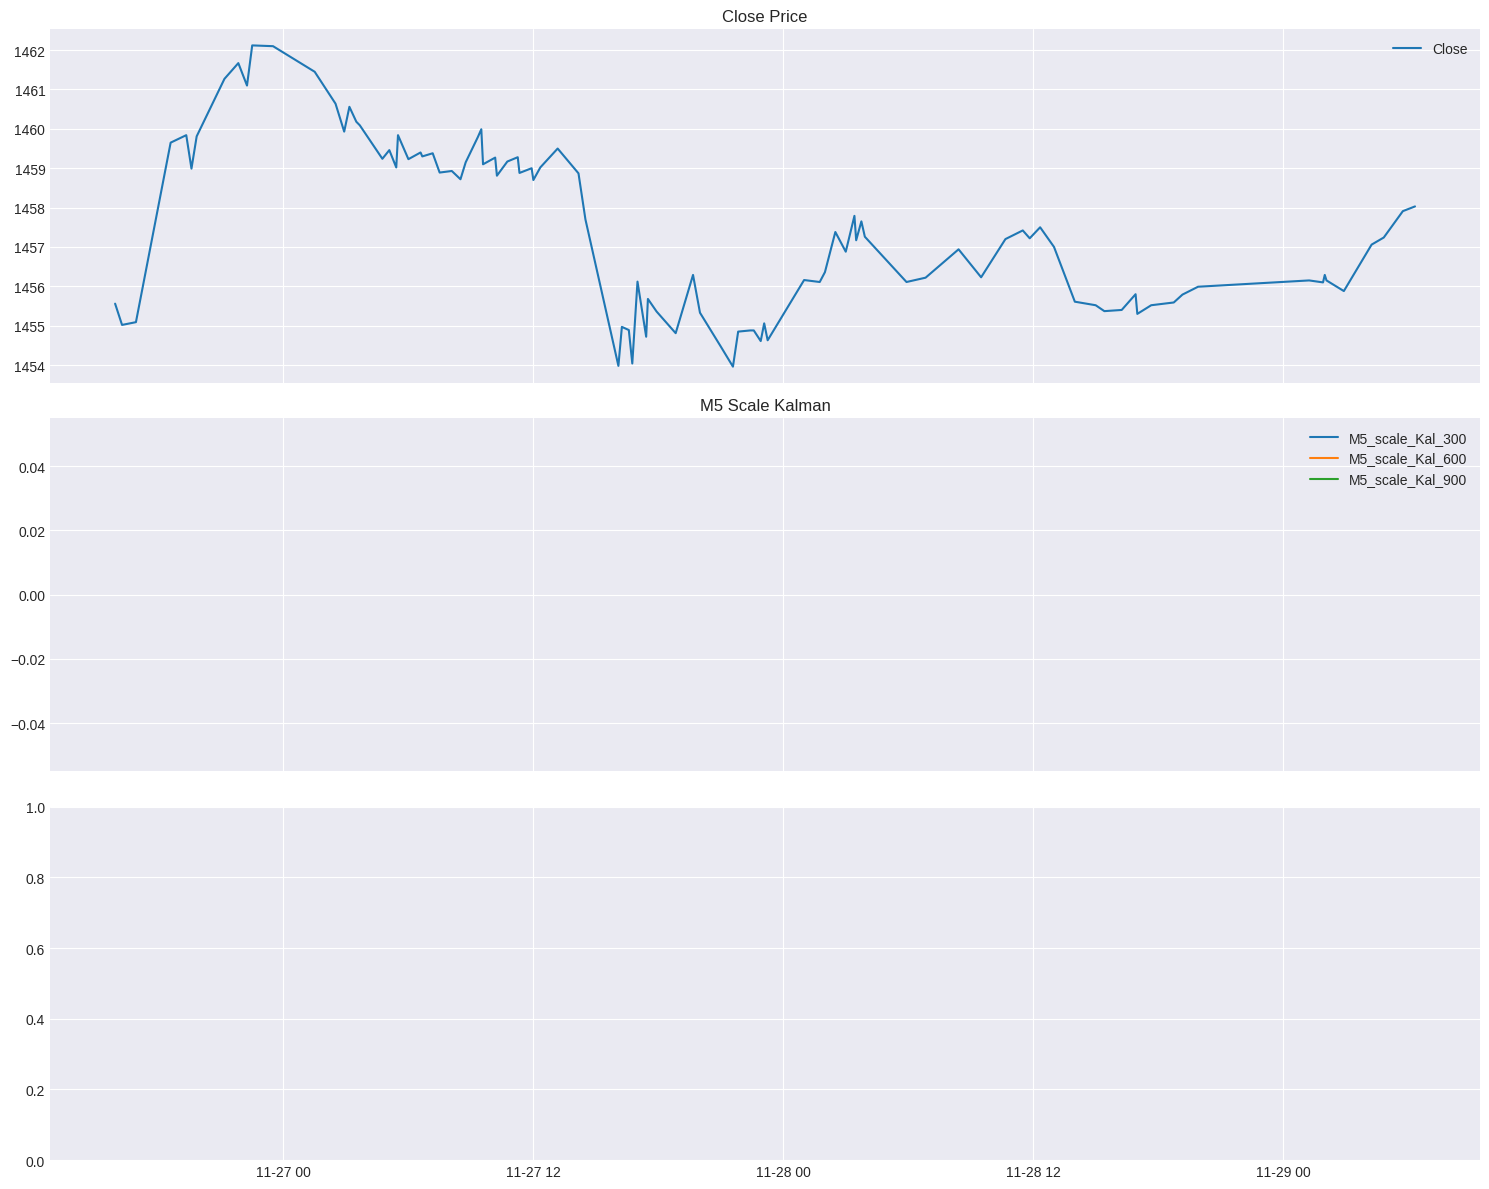

In [114]:
import matplotlib.pyplot as plt

# Define the row range for plotting
start_row = 9200
end_row = 9300

# Select the data for the specified row range from df
plot_df = df.iloc[start_row:end_row].copy()

# Define the columns to plot in each chart
chart1_cols = ['Close'] # Assuming 'Close' is now in df
chart2_cols = ['M5_scale_Kal_300', 'M5_scale_Kal_600', 'M5_scale_Kal_900']
chart3_cols = ['M5_scale_Close_Kal_Kal_300', 'M5_scale_Close_Kal_Kal_600', 'M5_scale_Close_Kal_Kal_900']


# Determine the number of subplots (only include charts with available columns in plot_df)
num_plots = 0
if any(col in plot_df.columns for col in chart1_cols): num_plots += 1
if any(col in plot_df.columns for col in chart2_cols): num_plots += 1
if any(col in plot_df.columns for col in chart3_cols): num_plots += 1
if any(col in plot_df.columns for col in chart4_cols): num_plots += 1
if any(col in plot_df.columns for col in chart5_cols): num_plots += 1 # Update num_plots


# Create the subplots
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(15, 4 * num_plots), sharex=True)

# Ensure axes is an array even if only one plot
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

current_plot_index = 0

# Plot Chart 1: Close Price
if any(col in plot_df.columns for col in chart1_cols):
    axes[current_plot_index].plot(plot_df['Date'], plot_df[chart1_cols])
    axes[current_plot_index].set_title('Close Price')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart1_cols)
    current_plot_index += 1


# Plot Chart 2: M5 Scale Kalman indicators
if any(col in plot_df.columns for col in chart2_cols):
    axes[current_plot_index].plot(plot_df['Date'], plot_df[chart2_cols])
    axes[current_plot_index].set_title('M5 Scale Kalman')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart2_cols)
    current_plot_index += 1

# Plot Chart 3: M5 Scale Kalman Change indicators
if any(col in plot_df.columns for col in chart3_cols):
    axes[current_plot_index].plot(plot_df['Date'], plot_df[chart3_cols])
    axes[current_plot_index].set_title('M5 Scale Kalman Change')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart3_cols)
    current_plot_index += 1


plt.tight_layout()
plt.show()

In [115]:
### Align feature directions so that shorts mirror longs
if 'Open_Trade' not in df.columns:
    raise KeyError("'Open_Trade' column is required in df to flip feature signs.")

### Identify feature columns to flip (exclude identifiers/targets).
feature_cols = [col for col in df.columns if col not in ['Date', 'label', 'Open_Trade', 'Close']] # Keep 'Close'
short_mask = df['Open_Trade'] == -1

if short_mask.any():
    df.loc[short_mask, feature_cols] = df.loc[short_mask, feature_cols] * -1
    print(f"Flipped {short_mask.sum()} rows with Open_Trade = -1.")
else:
    print("No rows with Open_Trade = -1 were found.")

### Reorder columns so Open_Trade stays next to the label for downstream steps.
ordered_cols = ['Date', 'label', 'Open_Trade'] + [col for col in feature_cols]
df = df[ordered_cols]

# Remove columns with 'raw' or 'RSI' in their name from df, but keep 'Close'
cols_to_drop = [col for col in df.columns if ('raw' in col or 'RSI' in col) and col != 'Close']
df = df.drop(columns=cols_to_drop, errors='ignore')
print(f"Dropped {len(cols_to_drop)} columns containing 'raw' or 'RSI' (keeping 'Close').")

Flipped 33857 rows with Open_Trade = -1.
Dropped 3 columns containing 'raw' or 'RSI' (keeping 'Close').


## ML

In [ ]:
# ===================== 1. ENTRENAR Y OBTENER IMPORTANCIAS =====================
def compute_xgb_importance(
    X: pd.DataFrame,
    y: pd.Series,
    task: str = "classification",
    random_state: int = 42,
    **xgb_params: Any
) -> Tuple[pd.DataFrame, Any]:
    """
    Entrena un modelo XGBoost y devuelve:
      - imp_df: DataFrame con 'feature', 'importance' y 'cum_importance'.
      - model : modelo ya entrenado.

    Soporta:
      • Clasificación binaria o multiclase (detecta nº de clases).
      • Regresión (si task != 'classification').

    Parámetros
    ----------
    X : pd.DataFrame
        Matriz de características (sin la columna objetivo).
    y : pd.Series
        Etiquetas objetivo. Puede ser binaria (0/1) o multiclase (0..K-1).
    task : str, opcional
        "classification" (default) o "regression".
    random_state : int, opcional
        Semilla para reproducibilidad.
    **xgb_params : dict
        Parámetros adicionales para el estimador de XGBoost.

    Returns
    -------
    (imp_df, model)
        imp_df : DataFrame con importancias y su acumulado.
        model  : instancia entrenada de XGBClassifier / XGBRegressor.
    """
    default_params: Dict[str, Any] = dict(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1,
        tree_method="hist",
    )
    default_params.update(xgb_params)

    if task == "classification":
        # Detectar nº de clases
        classes = np.unique(y)
        n_classes = len(classes)

        # XGBClassifier ajusta objetivo automáticamente, pero lo explicitamos:
        if n_classes > 2:
            default_params.setdefault("objective", "multi:softprob")
            default_params.setdefault("num_class", n_classes)
            eval_metric = "mlogloss"
        else:
            default_params.setdefault("objective", "binary:logistic")
            eval_metric = "logloss"

        model = XGBClassifier(eval_metric=eval_metric, **default_params)

    else:
        model = XGBRegressor(**default_params)

    model.fit(X, y)

    imp_df = (
        pd.DataFrame({
            "feature": X.columns,
            "importance": model.feature_importances_
        })
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )
    total_imp = imp_df["importance"].sum()
    if total_imp == 0:
        # Evitar división por cero si el modelo devuelve todo cero (raro, pero posible)
        imp_df["cum_importance"] = 0.0
    else:
        imp_df["cum_importance"] = imp_df["importance"].cumsum() / total_imp

    return imp_df, model

In [ ]:
# ===================== 2. SELECCIÓN DE FEATURES =====================
def select_features_with_importance(
    X: pd.DataFrame,
    imp_df: pd.DataFrame,
    top_n: Optional[int] = None,
    threshold: Optional[str | float] = None,
    cum_threshold: Optional[float] = 0.8
) -> Tuple[pd.DataFrame, List[str]]:
    """
    Selección flexible de variables a partir de importancias de XGBoost.

    Reglas:
      - Si top_n no es None           => usa el top_n.
      - Else si cum_threshold no None => usa importancia acumulada (p.ej. 0.8 = 80%).
      - Else usa threshold ('median', 'mean' o valor numérico).

    Devuelve (X_reducido, lista_de_features).

    Parámetros
    ----------
    X : pd.DataFrame
        Matriz de características original.
    imp_df : pd.DataFrame
        DataFrame devuelto por compute_xgb_importance.
    top_n : int | None
        Número fijo de variables a conservar.
    threshold : str | float | None
        Umbral de importancia. Si str, usar 'median' o 'mean'.
    cum_threshold : float | None
        Porcentaje acumulado de importancia (0-1). Si None, se ignora.

    Returns
    -------
    (X_sel, keep)
        X_sel : subset de X con columnas seleccionadas.
        keep  : lista de nombres de columnas seleccionadas.
    """
    if top_n is not None:
        keep = imp_df.head(top_n)["feature"].tolist()

    elif cum_threshold is not None:
        keep_mask = imp_df["cum_importance"] <= float(cum_threshold)
        keep = imp_df.loc[keep_mask, "feature"].tolist()
        # asegurar que haya al menos una más para no quedarnos exactamente en el corte
        if len(keep) < len(imp_df):
            keep.append(imp_df.iloc[len(keep)]["feature"])

    else:
        if threshold is None:
            threshold = "median"
        if isinstance(threshold, str):
            thr_val = imp_df["importance"].agg(threshold)
        else:
            thr_val = float(threshold)
        keep = imp_df.loc[imp_df["importance"] >= thr_val, "feature"].tolist()

    return X[keep], keep

In [ ]:
# ===================== 3. BÚSQUEDA DEL MEJOR UMBRAL ACUMULADO =====================
def find_best_cum_threshold(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_valid: pd.DataFrame,
    y_valid: pd.Series,
    task: str = "classification",
    thresholds: Tuple[float, ...] = (0.6, 0.7, 0.8, 0.9),
    random_state: int = 42,
    metric: str = "auto",
    **xgb_params: Any
) -> Tuple[float, pd.DataFrame, pd.DataFrame]:
    """
    Entrena un XGB en train, calcula importancias y prueba varios umbrales
    acumulados para ver cuál da la mejor métrica en valid.

    Para CLASIFICACIÓN:
        - Detecta nº de clases.
        - Métrica por defecto (metric="auto"):
            • Binaria: ROC-AUC (probabilidades de la clase positiva).
            • Multiclase: ROC-AUC macro OVR (usa predict_proba).
          Alternativas: metric="f1_macro", "accuracy", "logloss" (se MINIMIZA).
    Para REGRESIÓN:
        - Usa R^2.

    Devuelve:
        best_thr, res_df_ordenado_por_score_desc, imp_df

    Parámetros
    ----------
    X_train, y_train, X_valid, y_valid : pd.DataFrame / pd.Series
        Particiones de entrenamiento y validación.
    task : str
        "classification" (default) o "regression".
    thresholds : tuple[float, ...]
        Valores de umbral de importancia acumulada a evaluar (0-1).
    random_state : int
        Semilla para reproducibilidad.
    metric : str
        "auto" (default), "roc_auc", "f1_macro", "accuracy", "logloss" (clasif) o "r2" (regresión).
    **xgb_params : dict
        Parámetros extra para el estimador de XGBoost (pasan a compute y a los modelos internos).

    Returns
    -------
    (best_thr, res_df, imp_df)
        best_thr : float
            Umbral con mejor score (o menor logloss si metric='logloss').
        res_df : pd.DataFrame
            Tabla con resultados por umbral (n_features, score).
        imp_df : pd.DataFrame
            Importancias calculadas en X_train / y_train.
    """
    imp_df, _ = compute_xgb_importance(
        X_train, y_train, task=task, random_state=random_state, **xgb_params
    )

    results = []

    # Detectar nº de clases si es clasificación
    if task == "classification":
        classes = np.unique(y_train)
        n_classes = len(classes)
        if metric == "auto":
            metric_to_use = "roc_auc" if n_classes == 2 else "roc_auc"
        else:
            metric_to_use = metric
    else:
        metric_to_use = "r2" if metric == "auto" else metric

    for thr in thresholds:
        X_tr_sel, cols = select_features_with_importance(
            X_train, imp_df, cum_threshold=thr, top_n=None, threshold=None
        )
        X_va_sel = X_valid[cols]

        if task == "classification":
            params = dict(random_state=random_state, n_jobs=-1, tree_method="hist")
            params.update(xgb_params)

            if n_classes > 2:
                params.setdefault("objective", "multi:softprob")
                params.setdefault("num_class", n_classes)
                eval_metric = "mlogloss"
            else:
                params.setdefault("objective", "binary:logistic")
                eval_metric = "logloss"

            model_sel = XGBClassifier(eval_metric=eval_metric, **params)
            model_sel.fit(X_tr_sel, y_train)

            # Probabilidades y predicciones
            proba = model_sel.predict_proba(X_va_sel)
            pred  = np.argmax(proba, axis=1) if n_classes > 2 else (proba[:, 1] >= 0.5).astype(int)

            # Calcular métrica
            if metric_to_use == "roc_auc":
                if n_classes == 2:
                    score = roc_auc_score(y_valid, proba[:, 1])
                else:
                    # AUC macro One-vs-Rest
                    score = roc_auc_score(y_valid, proba, multi_class="ovr", average="macro")
            elif metric_to_use == "f1_macro":
                score = f1_score(y_valid, pred, average="macro")
            elif metric_to_use == "accuracy":
                score = accuracy_score(y_valid, pred)
            elif metric_to_use == "logloss":
                # En este caso, menor es mejor. Guardamos negativo para mantener criterio "mayor mejor".
                score = -log_loss(y_valid, proba, labels=np.unique(y_train))
            else:
                raise ValueError(f"Métrica no soportada: {metric_to_use}")

        else:
            # REGRESIÓN
            params = dict(random_state=random_state, n_jobs=-1, tree_method="hist")
            params.update(xgb_params)
            model_sel = XGBRegressor(**params)
            model_sel.fit(X_tr_sel, y_train)
            pred = model_sel.predict(X_va_sel)

            if metric_to_use == "r2":
                score = r2_score(y_valid, pred)
            else:
                raise ValueError(f"Métrica de regresión no soportada: {metric_to_use}")

        results.append({"cum_threshold": thr, "n_features": len(cols), "score": score})

    # Ordenar (si usamos logloss negado, mayor sigue siendo mejor)
    res_df = pd.DataFrame(results).sort_values("score", ascending=False).reset_index(drop=True)
    best_thr = float(res_df.iloc[0]["cum_threshold"])
    return best_thr, res_df, imp_df

In [ ]:
def remove_highly_correlated_features(df, threshold=0.9):

    # Solo numéricos para evitar errores y acelerar
    corr_matrix = df.corr(numeric_only=True).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1))

    to_drop = []
    for col in tqdm(upper.columns, desc=f"Pruning corr > {threshold}", unit="col", leave=False):
        if (upper[col] > threshold).any():
            to_drop.append(col)

    return df.drop(columns=to_drop, errors="ignore"), to_drop


In [ ]:
# ===================== 3. PIPELINE PRINCIPAL =====================
df = df.dropna()
y = df['label']
X = df.iloc[:, 2:]

# --- 3.3 Split temporal (ejemplo simple 80/20) ---
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# --- 3.4 Remove correlated features ---
X_train_filtered, dropped_features = remove_highly_correlated_features(X_train, threshold=0.9)
X_test_filtered = X_test.drop(columns=dropped_features)

# Baseline logistic regression with time-series CV
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_filtered)
tscv = TimeSeriesSplit(n_splits=5)
baseline = cross_val_score(LogisticRegression(max_iter=1000), X_scaled, y_train, cv=tscv).mean()
print('Logistic regression CV accuracy:', baseline)

# --- 3.5 Importancias con XGBoost ---
imp_df, xgb_model = compute_xgb_importance(X_train_filtered, y_train, task='classification')

print('=== Importancias XGBoost ===')
print(imp_df.head(20))
print(f'Total features: {len(imp_df)}')

# --- 3.6 Selección (elige una opción) ---
X_train_sel, keep_cols = select_features_with_importance(X_train_filtered, imp_df, cum_threshold=0.8)
X_test_sel = X_test_filtered[keep_cols]

print(f'Features seleccionadas: {len(keep_cols)}')
importance_map = imp_df.set_index("feature")["importance"]
selected_importances = pd.DataFrame({
    "feature": keep_cols,
    "importance": importance_map.reindex(keep_cols).values
})
selected_importances.to_csv(root_data+'Results/'+symbol+'_'+direction+'_M5M10_'+data_type+'_ImportantCols.csv', index=False)

# Save dataset with selected features
df_selected = df[['Date', 'label'] + keep_cols]
df_selected.to_csv(root_data+'Results/'+symbol+'_'+direction+'_M5M10_'+data_type+'_Features.csv', index=False)

# Time-series cross-validation with XGBoost
xgb_cv = XGBClassifier(eval_metric='logloss', n_estimators=500, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, tree_method='hist')
xgb_scores = cross_val_score(xgb_cv, X_train_sel, y_train, cv=tscv, scoring='accuracy')
print('XGBoost CV accuracy:', xgb_scores.mean())
